# Solve the problem leveraging ResNet-50 architecture
In this notebook, we will use the ResNet-50 architecture for our classification problem.

First, we'll try a simple **feature extraction**. Since the architecture was trained on a different dataset, we do not expect very good performance, but we can use these results as a baseline for the next step: **fine-tuning**.

## Import Libraries
First of all, let's import all the libraries we will need later.

In [1]:
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

## Set Parameters

In [2]:
DATASET_PATH = "SplittedDataset"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "content/drive/My Drive/Baldi_Cioffo/models/resnet-50"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [3]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  #metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  #Confusion Matrix
  cf_matrix = confusion_matrix(y_true, y_pred);
  sns.heatmap(cf_matrix, annot=True)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Load Dataset
The dataset, properly preprocessed, is now located in the local machine.

In [4]:
set_seed()

In [5]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.


## Feature extraction
Firstly, we use the pretrained network to extract feature and we define our classifiers to classify the images.

In [6]:
conv_base = keras.applications.resnet.ResNet50(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

In [7]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
conv_base.trainable = False

### Experiment 1: one dense layer with 64 neurons
In this first experiment we try a simple configuration with a single dense layer before the output layer.

In [9]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

Epoch 1/30
200/200 [==============================] - 222s 1s/step - loss: 1.2024 - accuracy: 0.7237 - val_loss: 0.6151 - val_accuracy: 0.7842

Epoch 00001: val_loss improved from inf to 0.61510, saving model to content/models/experiment1_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 214s 1s/step - loss: 0.5596 - accuracy: 0.8224 - val_loss: 0.8596 - val_accuracy: 0.7387

Epoch 00002: val_loss did not improve from 0.61510
Epoch 3/30
200/200 [==============================] - 216s 1s/step - loss: 0.2282 - accuracy: 0.9090 - val_loss: 0.4795 - val_accuracy: 0.8255

Epoch 00003: val_loss improved from 0.61510 to 0.47945, saving model to content/models/experiment1_feature_extraction.h5
Epoch 4/30
200/200 [==============================] - 217s 1s/step - loss: 0.1557 - accuracy: 0.9375 - val_loss: 0.4726 - val_accuracy: 0.8241

Epoch 00004: val_loss improved from 0.47945 to 0.47260, saving model to content/models/experiment1_feature_extraction.h5
Epoch 5/30
200/200 [==============================] - 215s 1s/step - loss: 0.0796 - accuracy: 0.9770 - val_loss: 0.5176 - val_accuracy: 0.8354

Epoch 00005: val_loss did not improve from 0.47260
Epoch 6/30
200/200 [==============================] - 219s 1s/step - loss: 0.096

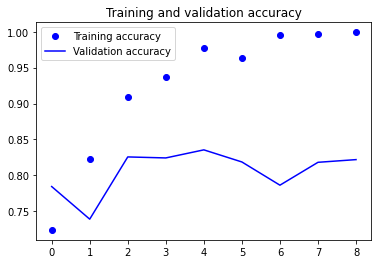

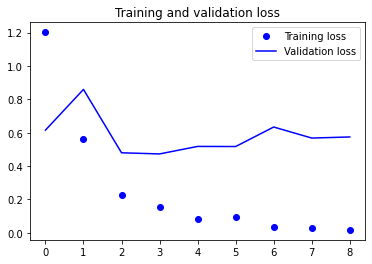

In [10]:
run_model(model1, 'experiment1_feature_extraction', epochs = 30)

Classification report: 
              precision    recall  f1-score   support

           0     0.6796    0.7773    0.7252       696
           1     0.8840    0.8224    0.8521      1436

    accuracy                         0.8077      2132
   macro avg     0.7818    0.7999    0.7886      2132
weighted avg     0.8173    0.8077    0.8107      2132



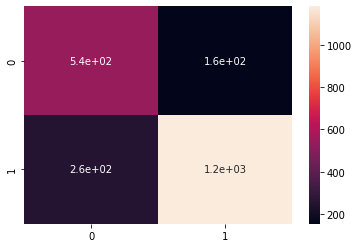

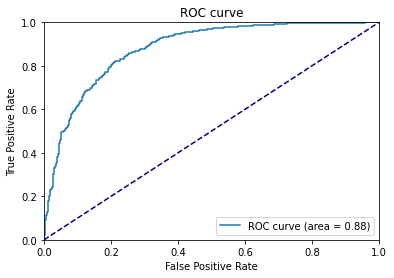

In [11]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5'))

### Experiment 2: one dense layer with 32 neurons
We tried to lower the number of neurons, to fight overfitting

In [12]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3211296   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33  

Epoch 1/30
200/200 [==============================] - 211s 1s/step - loss: 1.2356 - accuracy: 0.5011 - val_loss: 0.6920 - val_accuracy: 0.6576

Epoch 00001: val_loss improved from inf to 0.69200, saving model to content/models/experiment2_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 205s 1s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.6576

Epoch 00002: val_loss did not improve from 0.69200
Epoch 3/30
200/200 [==============================] - 210s 1s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.6576

Epoch 00003: val_loss did not improve from 0.69200
Epoch 4/30
200/200 [==============================] - 208s 1s/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6930 - val_accuracy: 0.6576

Epoch 00004: val_loss did not improve from 0.69200
Epoch 5/30
200/200 [==============================] - 209s 1s/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.3424

Epoch 00005: val_loss did not improve from 0.69200
Epoch 6/30
200/200 [==============================] - 209s 1s/step - loss: 0.6932 - accuracy: 0.4903 - val_loss: 0.6931 - val_accuracy: 0.6576

Epoch 00006: val_loss did not improve from 0.69200


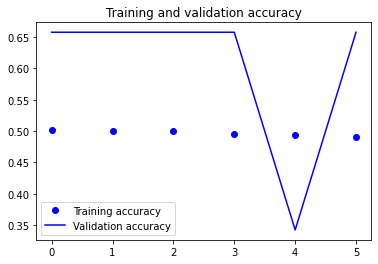

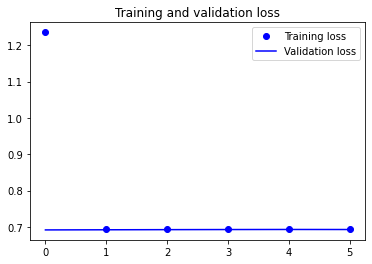

In [13]:
run_model(model2, 'experiment2_feature_extraction', epochs = 30)

Classification report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       696
           1     0.6735    1.0000    0.8049      1436

    accuracy                         0.6735      2132
   macro avg     0.3368    0.5000    0.4025      2132
weighted avg     0.4537    0.6735    0.5422      2132



/home/cseb21/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cseb21/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cseb21/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


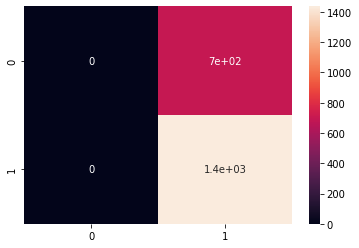

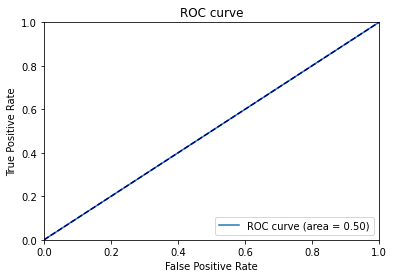

In [14]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction.h5'))

### Experiment 3: one dense layer with 64 neurons and dropout
Lowering the capacity of the networks leads us to underfitting, we could try to use Dropout instead.

In [15]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0   

Epoch 1/50
200/200 [==============================] - 213s 1s/step - loss: 1.3468 - accuracy: 0.5275 - val_loss: 0.6955 - val_accuracy: 0.6576

Epoch 00001: val_loss improved from inf to 0.69546, saving model to content/models/experiment3_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
200/200 [==============================] - 207s 1s/step - loss: 0.6935 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.3424

Epoch 00002: val_loss improved from 0.69546 to 0.69316, saving model to content/models/experiment3_feature_extraction.h5
Epoch 3/50
200/200 [==============================] - 209s 1s/step - loss: 0.6926 - accuracy: 0.4889 - val_loss: 0.6936 - val_accuracy: 0.3424

Epoch 00003: val_loss did not improve from 0.69316
Epoch 4/50
200/200 [==============================] - 209s 1s/step - loss: 0.6922 - accuracy: 0.5039 - val_loss: 0.6942 - val_accuracy: 0.3429

Epoch 00004: val_loss did not improve from 0.69316
Epoch 5/50
200/200 [==============================] - 210s 1s/step - loss: 0.6924 - accuracy: 0.5028 - val_loss: 0.6939 - val_accuracy: 0.3424

Epoch 00005: val_loss did not improve from 0.69316
Epoch 6/50
200/200 [==============================] - 210s 1s/step - loss: 0.6924 - accuracy: 0.4939 - val_loss: 0.6937 - val_accuracy: 0.3424

Epoch 

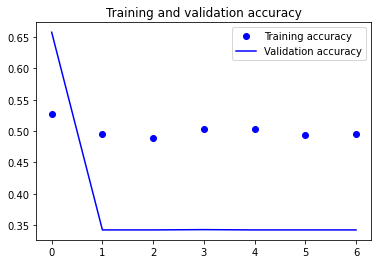

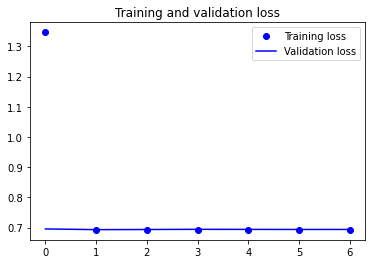

In [16]:
run_model(model3, 'experiment3_feature_extraction', epochs = 50)

Classification report: 
              precision    recall  f1-score   support

           0     0.3261    0.9986    0.4917       696
           1     0.0000    0.0000    0.0000      1436

    accuracy                         0.3260      2132
   macro avg     0.1631    0.4993    0.2458      2132
weighted avg     0.1065    0.3260    0.1605      2132



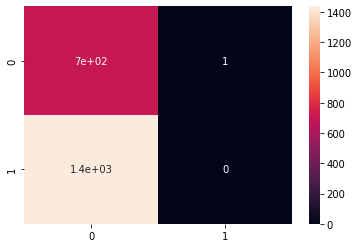

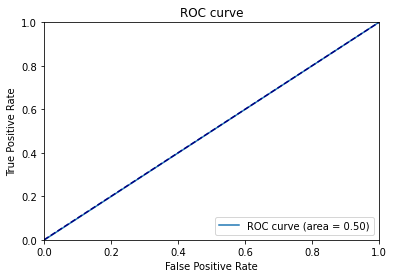

In [17]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction.h5'))

### Experiment 4: global average pooling
Try GlobalAveragePooling instead of fully connected layers, to lower the number of parameters.

In [18]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
___________________________________________

Epoch 1/20
200/200 [==============================] - 212s 1s/step - loss: 0.5438 - accuracy: 0.7287 - val_loss: 0.4944 - val_accuracy: 0.7697

Epoch 00001: val_loss improved from inf to 0.49442, saving model to content/models/experiment4_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
200/200 [==============================] - 210s 1s/step - loss: 0.4830 - accuracy: 0.7747 - val_loss: 0.6046 - val_accuracy: 0.6787

Epoch 00002: val_loss did not improve from 0.49442
Epoch 3/20
200/200 [==============================] - 210s 1s/step - loss: 0.4582 - accuracy: 0.7888 - val_loss: 0.4496 - val_accuracy: 0.8039

Epoch 00003: val_loss improved from 0.49442 to 0.44956, saving model to content/models/experiment4_feature_extraction.h5
Epoch 4/20
200/200 [==============================] - 214s 1s/step - loss: 0.4398 - accuracy: 0.8025 - val_loss: 0.4585 - val_accuracy: 0.7932

Epoch 00004: val_loss did not improve from 0.44956
Epoch 5/20
200/200 [==============================] - 211s 1s/step - loss: 0.4326 - accuracy: 0.8036 - val_loss: 0.4557 - val_accuracy: 0.7978

Epoch 00005: val_loss did not improve from 0.44956
Epoch 6/20
200/200 [==============================] - 213s 1s/step - loss: 0.4167 - accuracy: 0.8133 - val_loss: 0.3938 - val_accuracy: 0.8236

Epoch 

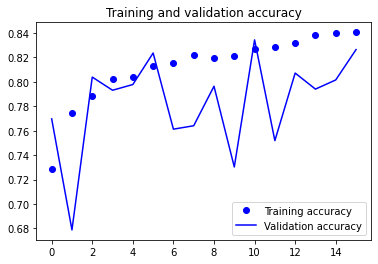

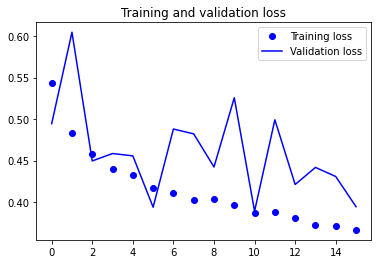

In [19]:
run_model(model4, "experiment4_feature_extraction", epochs=20)

Classification report: 
              precision    recall  f1-score   support

           0     0.7456    0.7241    0.7347       696
           1     0.8681    0.8802    0.8741      1436

    accuracy                         0.8293      2132
   macro avg     0.8068    0.8022    0.8044      2132
weighted avg     0.8281    0.8293    0.8286      2132



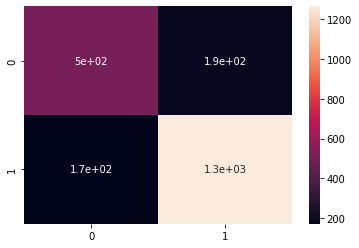

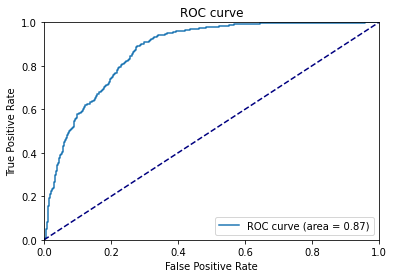

In [20]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_feature_extraction.h5'))

### Experiment 5: global average pooling and two dense layers

In [21]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model5, optimizer='rmsprop')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               2626

Epoch 1/50
200/200 [==============================] - 215s 1s/step - loss: 0.6776 - accuracy: 0.6954 - val_loss: 0.5137 - val_accuracy: 0.7608

Epoch 00001: val_loss improved from inf to 0.51366, saving model to content/models/Experiment5_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
200/200 [==============================] - 211s 1s/step - loss: 0.5010 - accuracy: 0.7591 - val_loss: 0.7060 - val_accuracy: 0.6285

Epoch 00002: val_loss did not improve from 0.51366
Epoch 3/50
200/200 [==============================] - 213s 1s/step - loss: 0.4611 - accuracy: 0.7855 - val_loss: 0.4298 - val_accuracy: 0.8204

Epoch 00003: val_loss improved from 0.51366 to 0.42984, saving model to content/models/Experiment5_feature_extraction.h5
Epoch 4/50
200/200 [==============================] - 211s 1s/step - loss: 0.4448 - accuracy: 0.7913 - val_loss: 0.4732 - val_accuracy: 0.8068

Epoch 00004: val_loss did not improve from 0.42984
Epoch 5/50
200/200 [==============================] - 210s 1s/step - loss: 0.4246 - accuracy: 0.8066 - val_loss: 0.3755 - val_accuracy: 0.8368

Epoch 00005: val_loss improved from 0.42984 to 0.37549, saving model to content/models/Experiment5_feature_extraction.h5
Epoch 6/50
200/200 [==============================] - 210s 1s/step - loss: 0.408

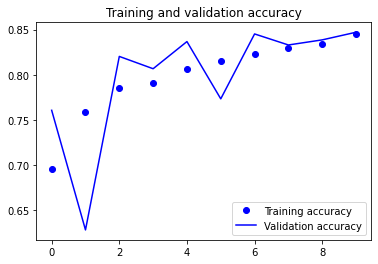

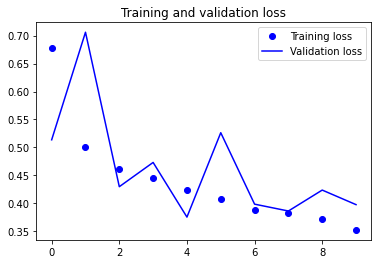

In [22]:
run_model(model5, 'Experiment5_feature_extraction', epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.8803    0.6020    0.7150       696
           1     0.8327    0.9603    0.8920      1436

    accuracy                         0.8433      2132
   macro avg     0.8565    0.7812    0.8035      2132
weighted avg     0.8482    0.8433    0.8342      2132



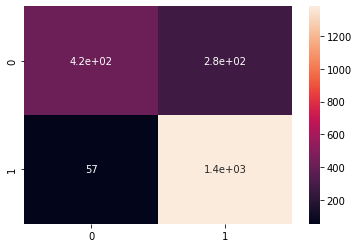

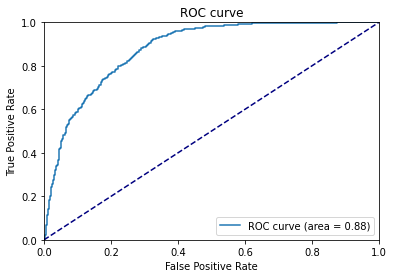

In [23]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_feature_extraction.h5'))

## Fine-tuning

### Experiment 1: one dense layer

In [24]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5')

set_trainable = False
for layer in model1.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model1, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

Epoch 1/50
200/200 [==============================] - 242s 1s/step - loss: 0.1432 - accuracy: 0.9428 - val_loss: 0.5990 - val_accuracy: 0.7871

Epoch 00001: val_loss improved from inf to 0.59895, saving model to content/models/experiment1_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
200/200 [==============================] - 236s 1s/step - loss: 0.0637 - accuracy: 0.9862 - val_loss: 0.5456 - val_accuracy: 0.8147

Epoch 00002: val_loss improved from 0.59895 to 0.54556, saving model to content/models/experiment1_fine_tuning.h5
Epoch 3/50
200/200 [==============================] - 239s 1s/step - loss: 0.0390 - accuracy: 0.9980 - val_loss: 0.5403 - val_accuracy: 0.8274

Epoch 00003: val_loss improved from 0.54556 to 0.54030, saving model to content/models/experiment1_fine_tuning.h5
Epoch 4/50
200/200 [==============================] - 238s 1s/step - loss: 0.0278 - accuracy: 0.9994 - val_loss: 0.5478 - val_accuracy: 0.8204

Epoch 00004: val_loss did not improve from 0.54030
Epoch 5/50
200/200 [==============================] - 239s 1s/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.5593 - val_accuracy: 0.8199

Epoch 00005: val_loss did not improve from 0.54030
Epoch 6/50
200/200 [==============================] - 240s 1s/step - loss: 0.0151 - accuracy: 

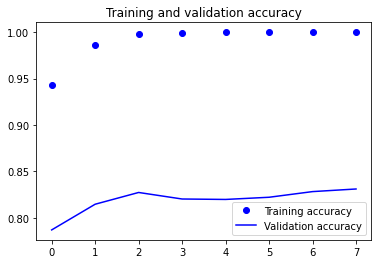

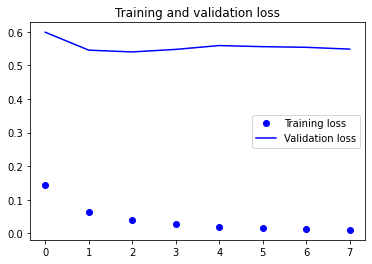

In [25]:
run_model(model1, "experiment1_fine_tuning", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.6748    0.7902    0.7280       696
           1     0.8891    0.8155    0.8507      1436

    accuracy                         0.8072      2132
   macro avg     0.7820    0.8028    0.7894      2132
weighted avg     0.8192    0.8072    0.8106      2132



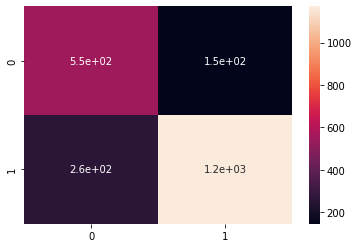

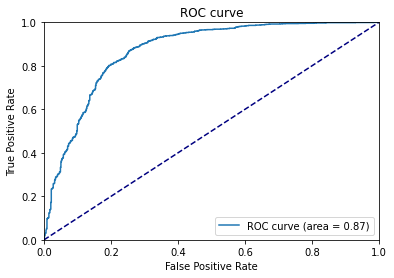

In [26]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_fine_tuning.h5'))

### Experiment 2: global average pooling

In [27]:
model4 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_feature_extraction.h5')

set_trainable = False
# fine-tune the last three elements
for layer in model4.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model4, learning_rate=1e-5)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 4,467,713
Non-trainable params: 19,122,048
_______________________________________

Epoch 1/20
200/200 [==============================] - 235s 1s/step - loss: 0.3957 - accuracy: 0.8236 - val_loss: 0.3977 - val_accuracy: 0.8241

Epoch 00001: val_loss improved from inf to 0.39767, saving model to content/models/Experiment2_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
200/200 [==============================] - 231s 1s/step - loss: 0.3280 - accuracy: 0.8640 - val_loss: 0.4001 - val_accuracy: 0.8185

Epoch 00002: val_loss did not improve from 0.39767
Epoch 3/20
200/200 [==============================] - 231s 1s/step - loss: 0.2851 - accuracy: 0.8910 - val_loss: 0.3855 - val_accuracy: 0.8227

Epoch 00003: val_loss improved from 0.39767 to 0.38545, saving model to content/models/Experiment2_fine_tuning.h5
Epoch 4/20
200/200 [==============================] - 233s 1s/step - loss: 0.2491 - accuracy: 0.9146 - val_loss: 0.3875 - val_accuracy: 0.8260

Epoch 00004: val_loss did not improve from 0.38545
Epoch 5/20
200/200 [==============================] - 236s 1s/step - loss: 0.2162 - accuracy: 0.9320 - val_loss: 0.3675 - val_accuracy: 0.8358

Epoch 00005: val_loss improved from 0.38545 to 0.36747, saving model to content/models/Experiment2_fine_tuning.h5
Epoch 6/20
200/200 [==============================] - 236s 1s/step - loss: 0.1887 - accuracy: 

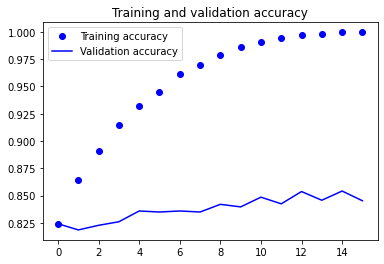

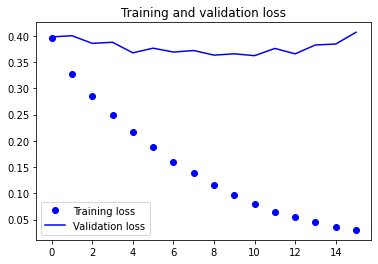

In [28]:
run_model(model4, "Experiment2_fine_tuning")

Classification report: 
              precision    recall  f1-score   support

           0     0.7154    0.8017    0.7561       696
           1     0.8979    0.8454    0.8709      1436

    accuracy                         0.8311      2132
   macro avg     0.8067    0.8236    0.8135      2132
weighted avg     0.8383    0.8311    0.8334      2132



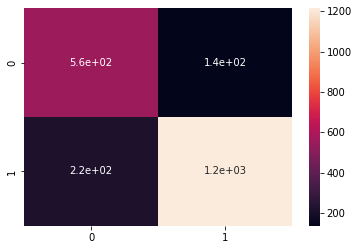

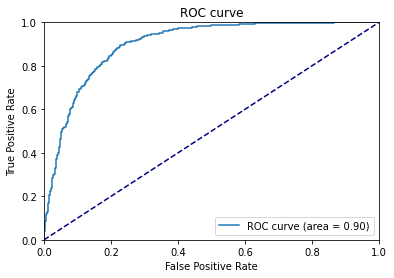

In [29]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_fine_tuning.h5'))

### Experiment 3: global average pooling and two dense layers

In [30]:
model5 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_feature_extraction.h5')

set_trainable = False
for layer in model5.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model5, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               2626

Epoch 1/50
200/200 [==============================] - 240s 1s/step - loss: 0.4378 - accuracy: 0.8222 - val_loss: 0.4401 - val_accuracy: 0.8204

Epoch 00001: val_loss improved from inf to 0.44007, saving model to content/models/Experiment3_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
200/200 [==============================] - 235s 1s/step - loss: 0.3183 - accuracy: 0.8605 - val_loss: 0.4193 - val_accuracy: 0.8293

Epoch 00002: val_loss improved from 0.44007 to 0.41933, saving model to content/models/Experiment3_fine_tuning.h5
Epoch 3/50
200/200 [==============================] - 236s 1s/step - loss: 0.2710 - accuracy: 0.8874 - val_loss: 0.4384 - val_accuracy: 0.8274

Epoch 00003: val_loss did not improve from 0.41933
Epoch 4/50
200/200 [==============================] - 237s 1s/step - loss: 0.2272 - accuracy: 0.9098 - val_loss: 0.4304 - val_accuracy: 0.8405

Epoch 00004: val_loss did not improve from 0.41933
Epoch 5/50
200/200 [==============================] - 238s 1s/step - loss: 0.1891 - accuracy: 0.9298 - val_loss: 0.4181 - val_accuracy: 0.8462

Epoch 00005: val_loss improved from 0.41933 to 0.41813, saving model to content/models/Experiment3_fine_tuning.h5
Epoch 6/50
200/200 [==============================] - 239s 1s/step - loss: 0.1517 - accuracy: 

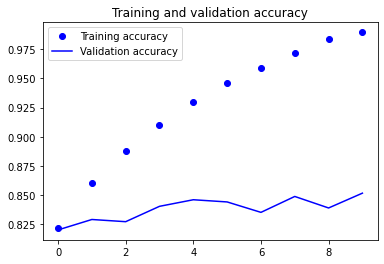

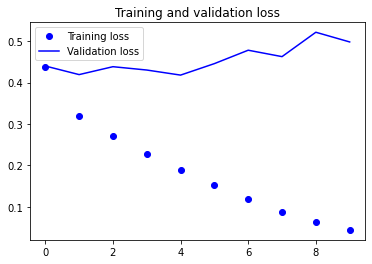

In [31]:
run_model(model5, "Experiment3_fine_tuning", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.7691    0.7371    0.7528       696
           1     0.8751    0.8928    0.8838      1436

    accuracy                         0.8419      2132
   macro avg     0.8221    0.8149    0.8183      2132
weighted avg     0.8405    0.8419    0.8410      2132



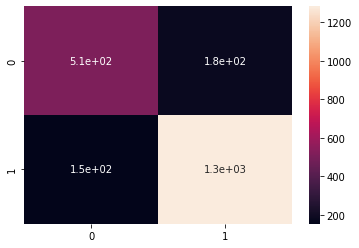

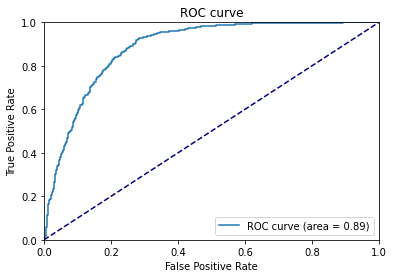

In [32]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_fine_tuning.h5'))

## Remove final block (5-th block)
Due to Colab's limitations we only took part of the original dataset, so now our dataset is small and very different from the one the pre-trained network was trained on. In this case it may be good to try to remove some of the final layers of the pre-trained network whose filters deal with finding detailed features. We will use less specific features that we find in previous levels.

In [33]:
def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

In [34]:
conv_base = keras.applications.resnet.ResNet50(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

Remove the last convolutionary block of ResNet50.

In [35]:
base = Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'conv4_block6_out')].output, name='base')
base.trainable = False
base.summary()

Model: "base"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________________

### Feature extraction
Firstly, we will try to use the new base network to extract the features; we will put a classifier on top of the base network. We couldn't afford to use the Flatten, the output of the base network is 14x14x1024, too much. So we decided to use the GlobalAveragePooling2D.

#### Experiment 1: one dense layer with 256 neurons
In this first example we use just a Dense layer before the output layer.

In [36]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_5 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_5 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257 

Epoch 1/30
200/200 [==============================] - 200s 988ms/step - loss: 0.6462 - accuracy: 0.7103 - val_loss: 0.5133 - val_accuracy: 0.7481

Epoch 00001: val_loss improved from inf to 0.51332, saving model to content/models/Experiment1_remove_blocks_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 197s 985ms/step - loss: 0.5086 - accuracy: 0.7558 - val_loss: 0.4165 - val_accuracy: 0.8194

Epoch 00002: val_loss improved from 0.51332 to 0.41652, saving model to content/models/Experiment1_remove_blocks_feature_extraction.h5
Epoch 3/30
200/200 [==============================] - 194s 969ms/step - loss: 0.5242 - accuracy: 0.7462 - val_loss: 0.3994 - val_accuracy: 0.8335

Epoch 00003: val_loss improved from 0.41652 to 0.39941, saving model to content/models/Experiment1_remove_blocks_feature_extraction.h5
Epoch 4/30
200/200 [==============================] - 197s 987ms/step - loss: 0.4640 - accuracy: 0.7861 - val_loss: 0.3985 - val_accuracy: 0.8279

Epoch 00004: val_loss improved from 0.39941 to 0.39847, saving model to content/models/Experiment1_remove_blocks_feature_extraction.h5
Epoch 5/30
200/200 [==============================] - 198s 992ms/step - loss: 0.4672 - accuracy: 0.7836 - val_loss: 0.3814 - val_accuracy: 0.8396

Epoch 0

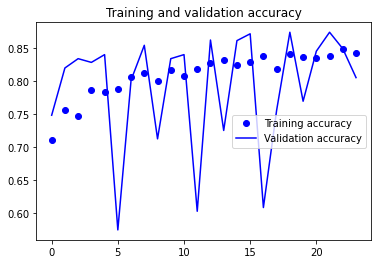

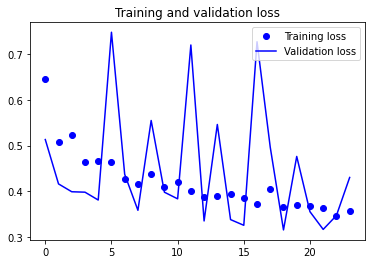

In [37]:
run_model(model1, "Experiment1_remove_blocks_feature_extraction", epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8387    0.7170    0.7730       696
           1     0.8718    0.9331    0.9014      1436

    accuracy                         0.8626      2132
   macro avg     0.8552    0.8251    0.8372      2132
weighted avg     0.8610    0.8626    0.8595      2132



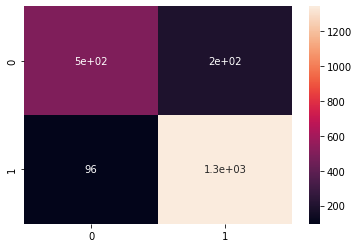

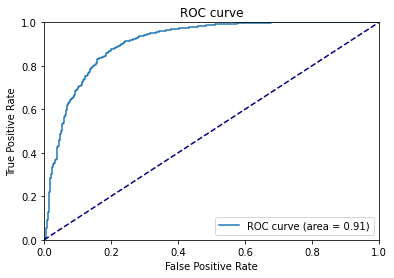

In [38]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction.h5'))

#### Experiment 2: one dense layer with 256 neurons and dropout
Try to use Dropout.

In [39]:
# define the classifier
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

Epoch 1/20
200/200 [==============================] - 204s 1s/step - loss: 0.6706 - accuracy: 0.6784 - val_loss: 0.4963 - val_accuracy: 0.7631

Epoch 00001: val_loss improved from inf to 0.49634, saving model to content/models/Experiment2_remove_blocks_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
200/200 [==============================] - 200s 1000ms/step - loss: 0.5945 - accuracy: 0.7145 - val_loss: 0.8089 - val_accuracy: 0.5535

Epoch 00002: val_loss did not improve from 0.49634
Epoch 3/20
200/200 [==============================] - 195s 975ms/step - loss: 0.5183 - accuracy: 0.7508 - val_loss: 0.5174 - val_accuracy: 0.7477

Epoch 00003: val_loss did not improve from 0.49634
Epoch 4/20
200/200 [==============================] - 196s 979ms/step - loss: 0.4961 - accuracy: 0.7647 - val_loss: 0.4109 - val_accuracy: 0.8265

Epoch 00004: val_loss improved from 0.49634 to 0.41090, saving model to content/models/Experiment2_remove_blocks_feature_extraction.h5
Epoch 5/20
200/200 [==============================] - 196s 983ms/step - loss: 0.4835 - accuracy: 0.7727 - val_loss: 0.4863 - val_accuracy: 0.7688

Epoch 00005: val_loss did not improve from 0.41090
Epoch 6/20
200/200 [==============================] - 197s 987ms/step - loss: 0.4868 - accuracy: 0.7611 - val_loss: 0.4245 

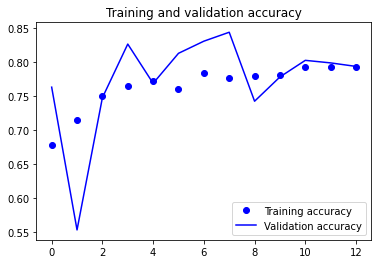

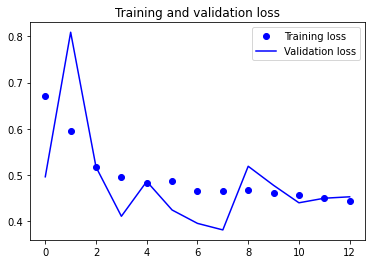

In [40]:
run_model(model2, "Experiment2_remove_blocks_feature_extraction")

Classification report: 
              precision    recall  f1-score   support

           0     0.8086    0.6494    0.7203       696
           1     0.8449    0.9255    0.8833      1436

    accuracy                         0.8354      2132
   macro avg     0.8267    0.7875    0.8018      2132
weighted avg     0.8330    0.8354    0.8301      2132



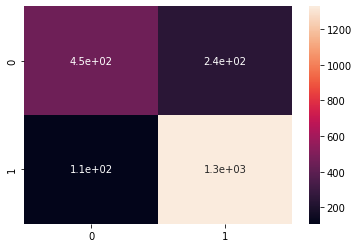

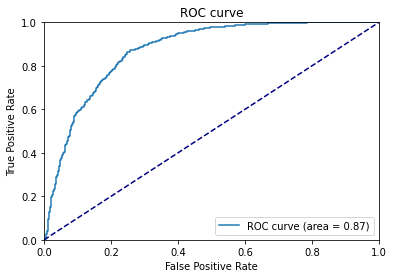

In [41]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5'))

#### Experiment 3: two dense layers, 256-128 neurons
Try to make a more complex network, increasing the dense layers.

In [42]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dense(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_7 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_7 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               3289

Epoch 1/20
200/200 [==============================] - 202s 999ms/step - loss: 0.6408 - accuracy: 0.7061 - val_loss: 0.5643 - val_accuracy: 0.7012

Epoch 00001: val_loss improved from inf to 0.56431, saving model to content/models/Experiment3_remove_blocks_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
200/200 [==============================] - 196s 981ms/step - loss: 0.4935 - accuracy: 0.7647 - val_loss: 0.6250 - val_accuracy: 0.6599

Epoch 00002: val_loss did not improve from 0.56431
Epoch 3/20
200/200 [==============================] - 195s 978ms/step - loss: 0.4918 - accuracy: 0.7628 - val_loss: 0.4879 - val_accuracy: 0.7749

Epoch 00003: val_loss improved from 0.56431 to 0.48786, saving model to content/models/Experiment3_remove_blocks_feature_extraction.h5
Epoch 4/20
200/200 [==============================] - 197s 986ms/step - loss: 0.4891 - accuracy: 0.7692 - val_loss: 0.4998 - val_accuracy: 0.7594

Epoch 00004: val_loss did not improve from 0.48786
Epoch 5/20
200/200 [==============================] - 198s 993ms/step - loss: 0.4549 - accuracy: 0.7872 - val_loss: 0.5569 - val_accuracy: 0.7144

Epoch 00005: val_loss did not improve from 0.48786
Epoch 6/20
200/200 [==============================] - 200s 999ms/step - loss: 0.4380 - accuracy: 0.7971 - val_loss: 0.5411 -

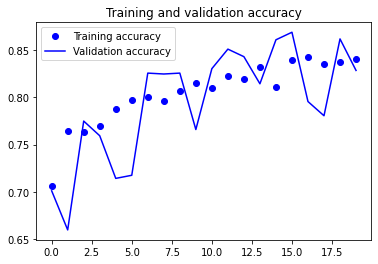

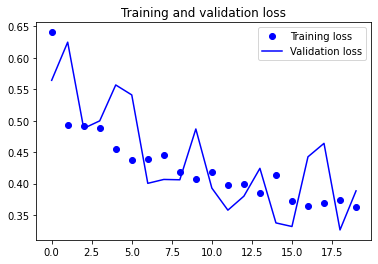

In [43]:
run_model(model3, "Experiment3_remove_blocks_feature_extraction")

Classification report: 
              precision    recall  f1-score   support

           0     0.7565    0.7989    0.7771       696
           1     0.8998    0.8753    0.8874      1436

    accuracy                         0.8504      2132
   macro avg     0.8281    0.8371    0.8322      2132
weighted avg     0.8530    0.8504    0.8514      2132



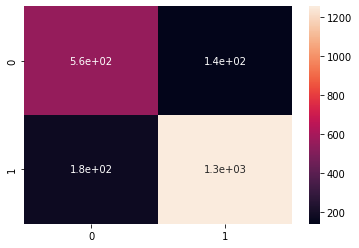

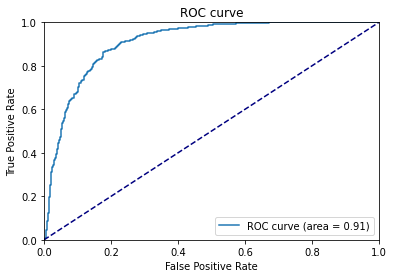

In [44]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_remove_blocks_feature_extraction.h5'))

#### Experiment 4: one dense layer with 512 neurons
Try to make a more complex networks increasing the neurons of a single Dense layer. We use RMSprop that in this case give us a smoother learning curve.

In [45]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4, optimizer='rmsprop', learning_rate=5e-5)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_8 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_8 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513 

Epoch 1/50
200/200 [==============================] - 198s 993ms/step - loss: 0.4185 - accuracy: 0.8097 - val_loss: 0.3767 - val_accuracy: 0.8447

Epoch 00001: val_loss improved from inf to 0.37671, saving model to content/models/Experiment4_remove_blocks_feature_extraction.h5
Epoch 2/50
200/200 [==============================] - 193s 965ms/step - loss: 0.4174 - accuracy: 0.8149 - val_loss: 0.4556 - val_accuracy: 0.7894

Epoch 00002: val_loss did not improve from 0.37671
Epoch 3/50
200/200 [==============================] - 192s 962ms/step - loss: 0.4155 - accuracy: 0.8146 - val_loss: 0.4114 - val_accuracy: 0.8185

Epoch 00003: val_loss did not improve from 0.37671
Epoch 4/50
200/200 [==============================] - 194s 973ms/step - loss: 0.4180 - accuracy: 0.8086 - val_loss: 0.4167 - val_accuracy: 0.8171

Epoch 00004: val_loss did not improve from 0.37671
Epoch 5/50
200/200 [==============================] - 192s 960ms/step - loss: 0.4088 - accuracy: 0.8210 - val_loss: 0.4756 - val

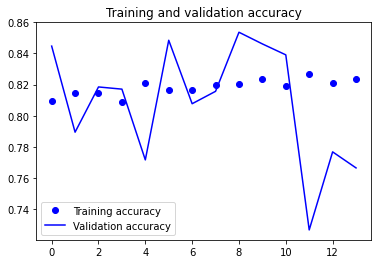

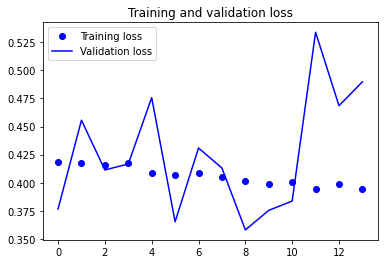

In [47]:
run_model(model4, "Experiment4_remove_blocks_feature_extraction", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.8185    0.6868    0.7469       696
           1     0.8592    0.9262    0.8914      1436

    accuracy                         0.8480      2132
   macro avg     0.8388    0.8065    0.8191      2132
weighted avg     0.8459    0.8480    0.8442      2132



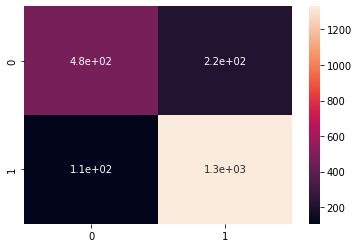

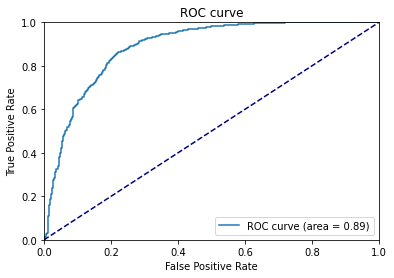

In [48]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5'))

#### Experiment 5: two dense layers of 512 neurons 
Try to make a more complex networks with two fully-connected dense layer of 512 neurons. We use RMSprop that in this case give us a smoother learning curve.

In [49]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model5, optimizer='rmsprop')

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_9 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               2626

Epoch 1/50
200/200 [==============================] - 199s 985ms/step - loss: 0.6602 - accuracy: 0.6723 - val_loss: 0.5498 - val_accuracy: 0.7509

Epoch 00001: val_loss improved from inf to 0.54982, saving model to content/models/Experiment5_remove_blocks_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
200/200 [==============================] - 194s 971ms/step - loss: 0.5520 - accuracy: 0.7308 - val_loss: 0.5320 - val_accuracy: 0.7627

Epoch 00002: val_loss improved from 0.54982 to 0.53199, saving model to content/models/Experiment5_remove_blocks_feature_extraction.h5
Epoch 3/50
200/200 [==============================] - 197s 985ms/step - loss: 0.5267 - accuracy: 0.7378 - val_loss: 0.4839 - val_accuracy: 0.8166

Epoch 00003: val_loss improved from 0.53199 to 0.48390, saving model to content/models/Experiment5_remove_blocks_feature_extraction.h5
Epoch 4/50
200/200 [==============================] - 197s 985ms/step - loss: 0.5120 - accuracy: 0.7484 - val_loss: 0.5943 - val_accuracy: 0.7083

Epoch 00004: val_loss did not improve from 0.48390
Epoch 5/50
200/200 [==============================] - 196s 983ms/step - loss: 0.5006 - accuracy: 0.7611 - val_loss: 0.4277 - val_accuracy: 0.8288

Epoch 00005: val_loss improved from 0.48390 to 0.42766, saving model to content/models/Expe

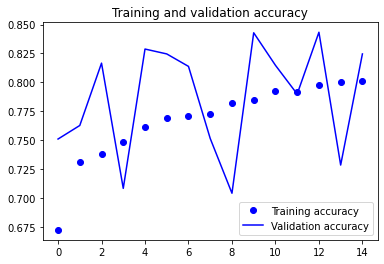

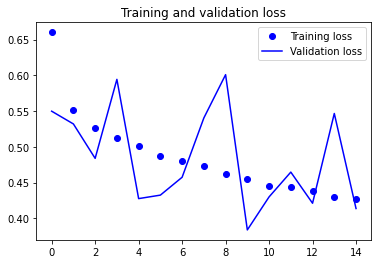

In [50]:
run_model(model5, "Experiment5_remove_blocks_feature_extraction", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.8202    0.6293    0.7122       696
           1     0.8385    0.9331    0.8833      1436

    accuracy                         0.8340      2132
   macro avg     0.8294    0.7812    0.7978      2132
weighted avg     0.8326    0.8340    0.8275      2132



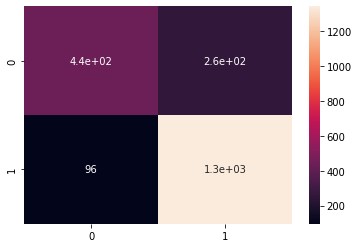

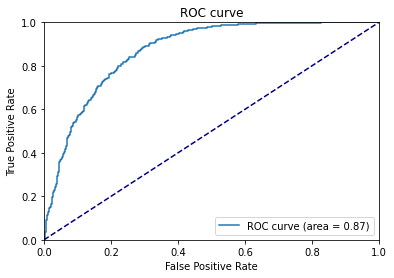

In [51]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5'))

### Fine tuning
Now we can fine tune the best models of the previous experiments, unfreezing some of the last layers of the base network.

#### Unfreeze some layers
Firstly, we try to unfreeze just some of the last layers of the fourth block.

##### Experiment 1: one dense layer with 256 neurons and dropout

In [52]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
# set trainable from "conv4_block6_1_conv"
for layer in model1.get_layer('base').layers:
    if layer.name == 'conv4_block6_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

In [53]:
compile_model(model1, learning_rate=1e-5)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

Epoch 1/30
200/200 [==============================] - 217s 1s/step - loss: 0.4327 - accuracy: 0.8032 - val_loss: 0.3749 - val_accuracy: 0.8471

Epoch 00001: val_loss improved from inf to 0.37493, saving model to content/models/Experiment1_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 210s 1s/step - loss: 0.4162 - accuracy: 0.8125 - val_loss: 0.3669 - val_accuracy: 0.8452

Epoch 00002: val_loss improved from 0.37493 to 0.36688, saving model to content/models/Experiment1_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 212s 1s/step - loss: 0.3950 - accuracy: 0.8275 - val_loss: 0.3531 - val_accuracy: 0.8513

Epoch 00003: val_loss improved from 0.36688 to 0.35306, saving model to content/models/Experiment1_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 215s 1s/step - loss: 0.3721 - accuracy: 0.8386 - val_loss: 0.3572 - val_accuracy: 0.8447

Epoch 00004: val_loss did not improve from 0.35306
Epoch 5/30
200/200 [==============================] - 215s 1s/step - loss: 0.3547 - accuracy: 0.8483 - val_loss: 0.3539 - val_accuracy: 0.8433

Epoch 00005: val_loss did not improve from 0.35306
Epoch 6/30
200/200 [==============================] - 214s 1s/step

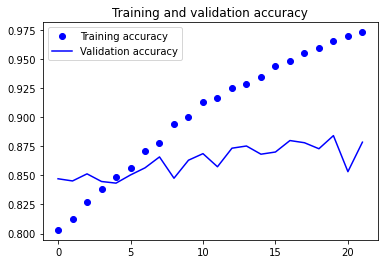

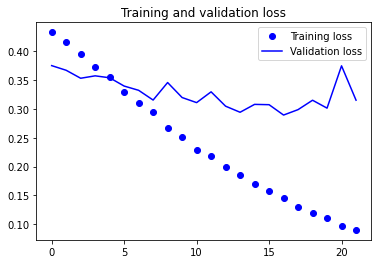

In [54]:
run_model(model1, 'Experiment1_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.7488    0.8693    0.8045       696
           1     0.9313    0.8586    0.8935      1436

    accuracy                         0.8621      2132
   macro avg     0.8400    0.8639    0.8490      2132
weighted avg     0.8717    0.8621    0.8644      2132



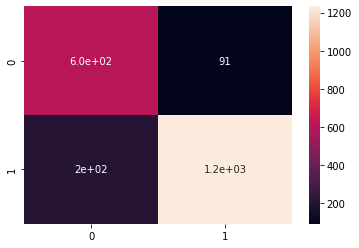

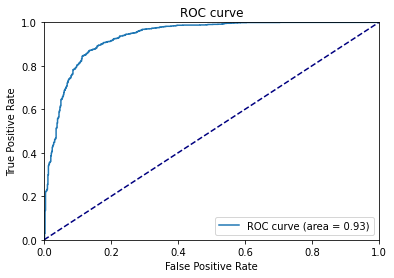

In [55]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_fine_tuning.h5'))

##### Experiment 2: one dense layer with 512 neurons

In [56]:
model2 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
set_trainable = False
# set trainable from "conv4_block6_1_conv"
for layer in model2.get_layer('base').layers:
    if layer.name == 'conv4_block6_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

In [57]:
compile_model(model2, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_8 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_8 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513 

Epoch 1/30
200/200 [==============================] - 211s 1s/step - loss: 0.1375 - accuracy: 0.9568 - val_loss: 0.3227 - val_accuracy: 0.8696

Epoch 00001: val_loss improved from inf to 0.32273, saving model to content/models/Experiment2_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 210s 1s/step - loss: 0.1286 - accuracy: 0.9593 - val_loss: 0.3497 - val_accuracy: 0.8621

Epoch 00002: val_loss did not improve from 0.32273
Epoch 3/30
200/200 [==============================] - 210s 1s/step - loss: 0.1155 - accuracy: 0.9648 - val_loss: 0.3735 - val_accuracy: 0.8494

Epoch 00003: val_loss did not improve from 0.32273
Epoch 4/30
200/200 [==============================] - 211s 1s/step - loss: 0.1124 - accuracy: 0.9633 - val_loss: 0.2875 - val_accuracy: 0.8888

Epoch 00004: val_loss improved from 0.32273 to 0.28751, saving model to content/models/Experiment2_remove_blocks_fine_tuning.h5
Epoch 5/30
200/200 [==============================] - 212s 1s/step - loss: 0.0960 - accuracy: 0.9719 - val_loss: 0.3096 - val_accuracy: 0.8795

Epoch 00005: val_loss did not improve from 0.28751
Epoch 6/30
200/200 [==============================] - 210s 1s/step - loss: 0.0912 - accuracy: 0.9701 - val_loss: 0.3586 - val_accuracy: 0.8654


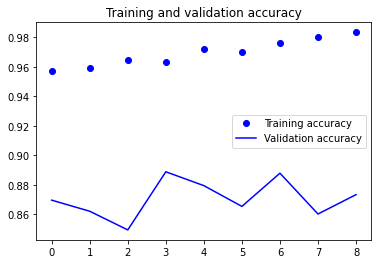

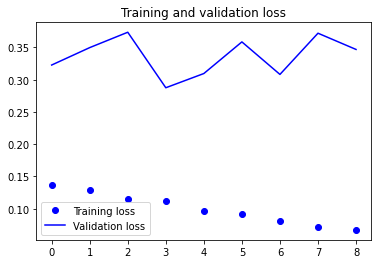

In [60]:
run_model(model2, 'Experiment2_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.7535    0.8606    0.8035       696
           1     0.9274    0.8635    0.8943      1436

    accuracy                         0.8626      2132
   macro avg     0.8405    0.8621    0.8489      2132
weighted avg     0.8706    0.8626    0.8647      2132



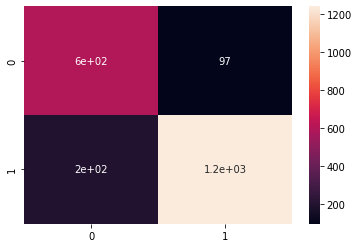

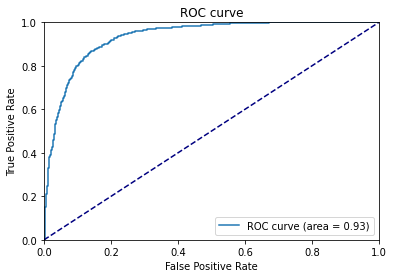

In [61]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_fine_tuning.h5'))

#### Unfreeze all the 4-th block
We try to unfreeze more layers, more precisely all the fourth block (that is the last block of our base network).

##### Experiment 3: one dense layer with 256 neurons and dropout

In [62]:
model3 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
# set trainable all conv4 section
for layer in model3.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [63]:
compile_model(model3, learning_rate=1e-5)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

Epoch 1/30
200/200 [==============================] - 305s 2s/step - loss: 0.4087 - accuracy: 0.8164 - val_loss: 0.4302 - val_accuracy: 0.8002

Epoch 00001: val_loss improved from inf to 0.43019, saving model to content/models/Experiment3_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 299s 1s/step - loss: 0.2960 - accuracy: 0.8748 - val_loss: 0.2885 - val_accuracy: 0.8776

Epoch 00002: val_loss improved from 0.43019 to 0.28851, saving model to content/models/Experiment3_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 303s 2s/step - loss: 0.2148 - accuracy: 0.9203 - val_loss: 0.2217 - val_accuracy: 0.9128

Epoch 00003: val_loss improved from 0.28851 to 0.22166, saving model to content/models/Experiment3_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 302s 2s/step - loss: 0.1396 - accuracy: 0.9495 - val_loss: 0.2113 - val_accuracy: 0.9203

Epoch 00004: val_loss improved from 0.22166 to 0.21126, saving model to content/models/Experiment3_remove_blocks_fine_tuning.h5
Epoch 5/30
200/200 [==============================] - 300s 2s/step - loss: 0.0812 - accuracy: 0.9742 - val_loss: 0.2145 - val_accuracy: 0.9254

Epoch 00005: val_loss did not improve fr

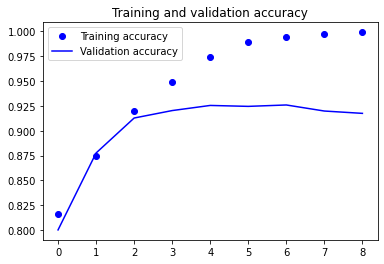

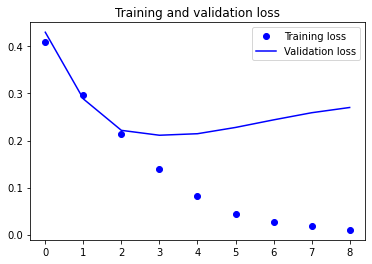

In [64]:
run_model(model3, 'Experiment3_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9105    0.8190    0.8623       696
           1     0.9163    0.9610    0.9381      1436

    accuracy                         0.9146      2132
   macro avg     0.9134    0.8900    0.9002      2132
weighted avg     0.9144    0.9146    0.9134      2132



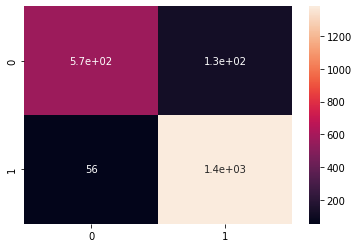

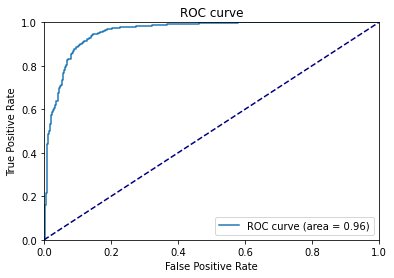

In [65]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_remove_blocks_fine_tuning.h5'))

##### Experiment 4: one dense layer with 512 neurons

In [66]:
model4 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
set_trainable = False
for layer in model4.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model4, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_8 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_8 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513 

Epoch 1/30
200/200 [==============================] - 307s 2s/step - loss: 0.3607 - accuracy: 0.8419 - val_loss: 0.3931 - val_accuracy: 0.8250

Epoch 00001: val_loss improved from inf to 0.39315, saving model to content/models/Experiment4_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 303s 2s/step - loss: 0.2624 - accuracy: 0.8959 - val_loss: 0.2531 - val_accuracy: 0.9006

Epoch 00002: val_loss improved from 0.39315 to 0.25309, saving model to content/models/Experiment4_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 303s 2s/step - loss: 0.1828 - accuracy: 0.9332 - val_loss: 0.2272 - val_accuracy: 0.9114

Epoch 00003: val_loss improved from 0.25309 to 0.22720, saving model to content/models/Experiment4_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 301s 2s/step - loss: 0.1273 - accuracy: 0.9581 - val_loss: 0.2262 - val_accuracy: 0.9160

Epoch 00004: val_loss improved from 0.22720 to 0.22624, saving model to content/models/Experiment4_remove_blocks_fine_tuning.h5
Epoch 5/30
200/200 [==============================] - 301s 2s/step - loss: 0.0709 - accuracy: 0.9826 - val_loss: 0.2406 - val_accuracy: 0.9174

Epoch 00005: val_loss did not improve fr

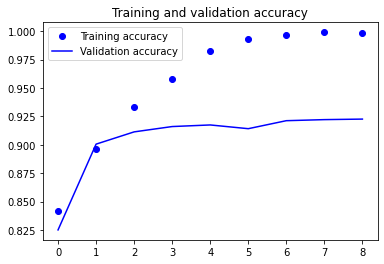

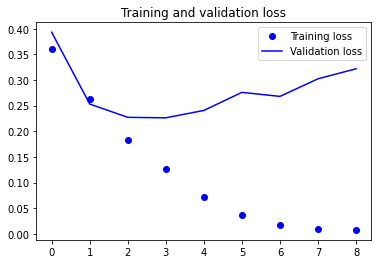

In [67]:
run_model(model4, 'Experiment4_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9112    0.7960    0.8497       696
           1     0.9068    0.9624    0.9338      1436

    accuracy                         0.9081      2132
   macro avg     0.9090    0.8792    0.8917      2132
weighted avg     0.9082    0.9081    0.9063      2132



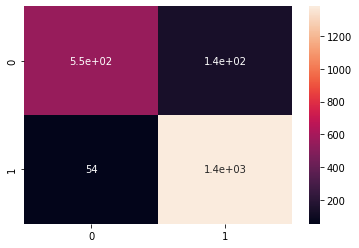

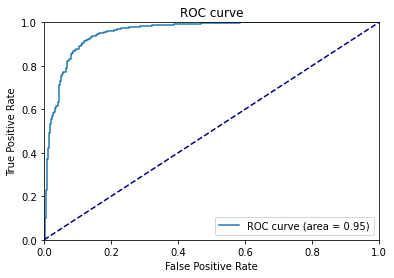

In [68]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_fine_tuning.h5'))

##### Experiment 5: two dense layers of 512 neurons 

In [69]:
model5 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5')
set_trainable = False
for layer in model5.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model5, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_9 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               2626

Epoch 1/30
200/200 [==============================] - 304s 1s/step - loss: 0.3746 - accuracy: 0.8324 - val_loss: 0.3294 - val_accuracy: 0.8649

Epoch 00001: val_loss improved from inf to 0.32938, saving model to content/models/Experiment5_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 299s 1s/step - loss: 0.2702 - accuracy: 0.8907 - val_loss: 0.2803 - val_accuracy: 0.8860

Epoch 00002: val_loss improved from 0.32938 to 0.28026, saving model to content/models/Experiment5_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 301s 2s/step - loss: 0.1947 - accuracy: 0.9264 - val_loss: 0.2251 - val_accuracy: 0.9109

Epoch 00003: val_loss improved from 0.28026 to 0.22512, saving model to content/models/Experiment5_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 299s 1s/step - loss: 0.1297 - accuracy: 0.9559 - val_loss: 0.2214 - val_accuracy: 0.9132

Epoch 00004: val_loss improved from 0.22512 to 0.22143, saving model to content/models/Experiment5_remove_blocks_fine_tuning.h5
Epoch 5/30
200/200 [==============================] - 301s 2s/step - loss: 0.0809 - accuracy: 0.9756 - val_loss: 0.2934 - val_accuracy: 0.8996

Epoch 00005: val_loss did not improve fr

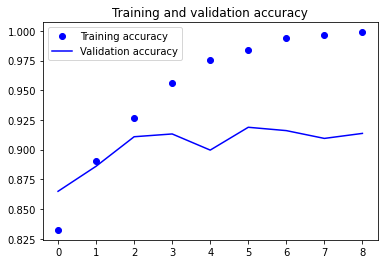

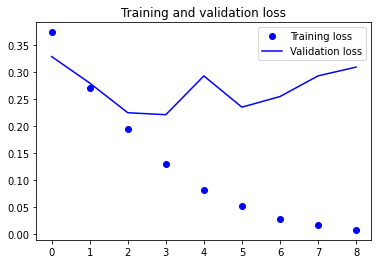

In [70]:
run_model(model5, 'Experiment5_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9148    0.8017    0.8545       696
           1     0.9093    0.9638    0.9358      1436

    accuracy                         0.9109      2132
   macro avg     0.9120    0.8828    0.8951      2132
weighted avg     0.9111    0.9109    0.9092      2132



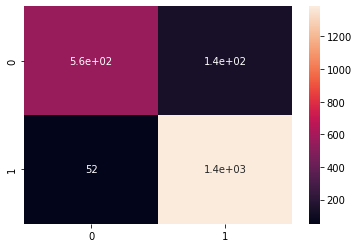

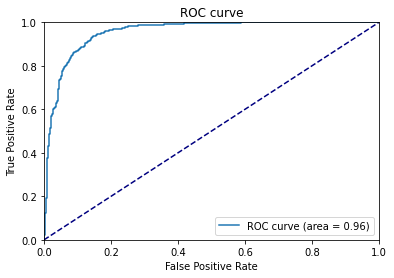

In [71]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_fine_tuning.h5'))

#### Unfreeze also the third block
We saw an improvement of our models, so we keep to unfreeze more layers. Now we unfreeze also the third block of our base network.

##### Experiment 6: one dense layer with 256 neurons and dropout

In [72]:
model6 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model6.get_layer('base').layers:
    if layer.name == 'conv3_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model6, learning_rate=1e-5)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

Epoch 1/30
200/200 [==============================] - 439s 2s/step - loss: 0.3849 - accuracy: 0.8324 - val_loss: 0.2897 - val_accuracy: 0.8813

Epoch 00001: val_loss improved from inf to 0.28973, saving model to content/models/Experiment6_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 431s 2s/step - loss: 0.2465 - accuracy: 0.8990 - val_loss: 0.2075 - val_accuracy: 0.9231

Epoch 00002: val_loss improved from 0.28973 to 0.20748, saving model to content/models/Experiment6_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 431s 2s/step - loss: 0.1682 - accuracy: 0.9351 - val_loss: 0.1807 - val_accuracy: 0.9301

Epoch 00003: val_loss improved from 0.20748 to 0.18075, saving model to content/models/Experiment6_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 428s 2s/step - loss: 0.1007 - accuracy: 0.9661 - val_loss: 0.1743 - val_accuracy: 0.9376

Epoch 00004: val_loss improved from 0.18075 to 0.17434, saving model to content/models/Experiment6_remove_blocks_fine_tuning.h5
Epoch 5/30
200/200 [==============================] - 429s 2s/step - loss: 0.0596 - accuracy: 0.9814 - val_loss: 0.1732 - val_accuracy: 0.9414

Epoch 00005: val_loss improved from 0.17

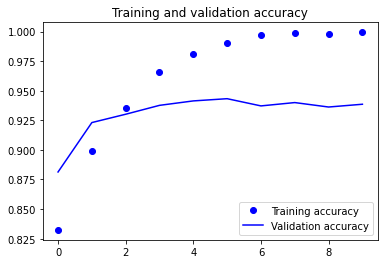

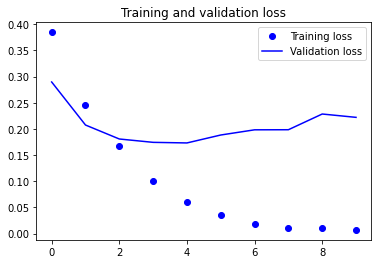

In [73]:
run_model(model6, 'Experiment6_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9107    0.8937    0.9021       696
           1     0.9489    0.9575    0.9532      1436

    accuracy                         0.9367      2132
   macro avg     0.9298    0.9256    0.9277      2132
weighted avg     0.9364    0.9367    0.9365      2132



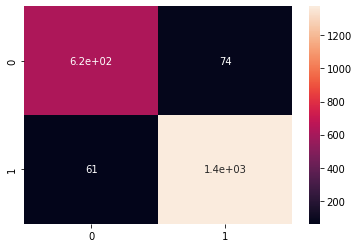

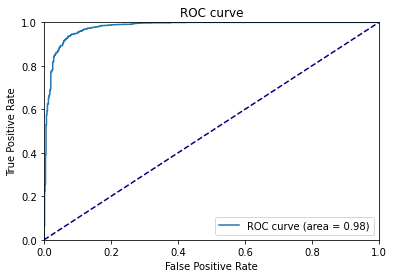

In [74]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment6_remove_blocks_fine_tuning.h5'))

##### Experiment 7: one dense layer with 512 neurons

In [75]:
model7 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model7.get_layer('base').layers:
    if layer.name == 'conv3_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model7, optimizer='rmsprop', learning_rate=1e-5)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_8 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_8 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513 

Epoch 1/30
200/200 [==============================] - 441s 2s/step - loss: 0.3417 - accuracy: 0.8552 - val_loss: 0.2645 - val_accuracy: 0.8954

Epoch 00001: val_loss improved from inf to 0.26446, saving model to content/models/Experiment7_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 433s 2s/step - loss: 0.2189 - accuracy: 0.9135 - val_loss: 0.2090 - val_accuracy: 0.9207

Epoch 00002: val_loss improved from 0.26446 to 0.20904, saving model to content/models/Experiment7_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 434s 2s/step - loss: 0.1440 - accuracy: 0.9493 - val_loss: 0.2101 - val_accuracy: 0.9264

Epoch 00003: val_loss did not improve from 0.20904
Epoch 4/30
200/200 [==============================] - 437s 2s/step - loss: 0.0858 - accuracy: 0.9733 - val_loss: 0.1858 - val_accuracy: 0.9306

Epoch 00004: val_loss improved from 0.20904 to 0.18578, saving model to content/models/Experiment7_remove_blocks_fine_tuning.h5
Epoch 5/30
200/200 [==============================] - 435s 2s/step - loss: 0.0482 - accuracy: 0.9869 - val_loss: 0.1844 - val_accuracy: 0.9381

Epoch 00005: val_loss improved from 0.18578 to 0.18436, saving model to content/models/Experiment7_remove_blocks_fine

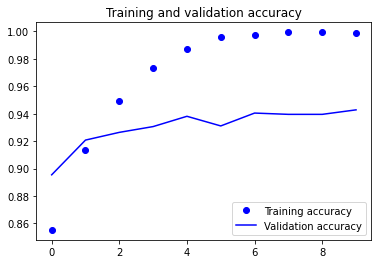

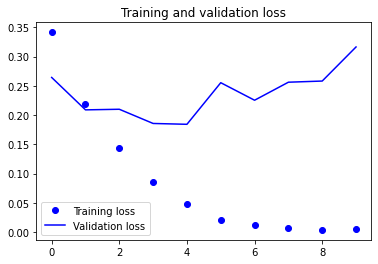

In [76]:
run_model(model7, 'Experiment7_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.9159    0.8764    0.8957       696
           1     0.9413    0.9610    0.9511      1436

    accuracy                         0.9334      2132
   macro avg     0.9286    0.9187    0.9234      2132
weighted avg     0.9330    0.9334    0.9330      2132



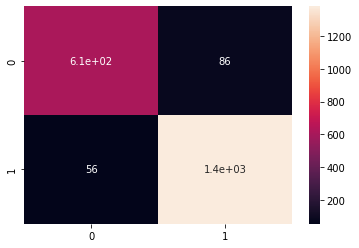

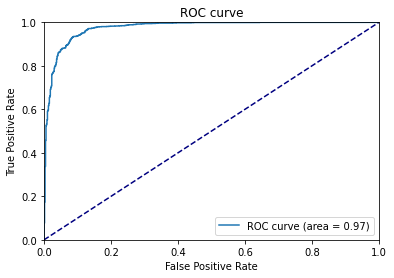

In [77]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment7_remove_blocks_fine_tuning.h5'))

#### Unfreeze also the second block
We try to unfreeze also the entire second block

##### Experiment 8: one dense layer with 256 neurons and dropout

In [78]:
model8 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model8.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model8, learning_rate=1e-5)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

Epoch 1/30
200/200 [==============================] - 618s 3s/step - loss: 0.3451 - accuracy: 0.8499 - val_loss: 0.5202 - val_accuracy: 0.8246

Epoch 00001: val_loss improved from inf to 0.52019, saving model to content/models/Experiment8_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 614s 3s/step - loss: 0.2333 - accuracy: 0.9065 - val_loss: 0.2233 - val_accuracy: 0.9109

Epoch 00002: val_loss improved from 0.52019 to 0.22328, saving model to content/models/Experiment8_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 609s 3s/step - loss: 0.1544 - accuracy: 0.9422 - val_loss: 0.1725 - val_accuracy: 0.9306

Epoch 00003: val_loss improved from 0.22328 to 0.17249, saving model to content/models/Experiment8_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 603s 3s/step - loss: 0.1100 - accuracy: 0.9586 - val_loss: 0.1765 - val_accuracy: 0.9320

Epoch 00004: val_loss did not improve from 0.17249
Epoch 5/30
200/200 [==============================] - 604s 3s/step - loss: 0.0592 - accuracy: 0.9822 - val_loss: 0.1727 - val_accuracy: 0.9404

Epoch 00005: val_loss did not improve from 0.17249
Epoch 6/30
200/200 [==============================] - 604s 3s/step

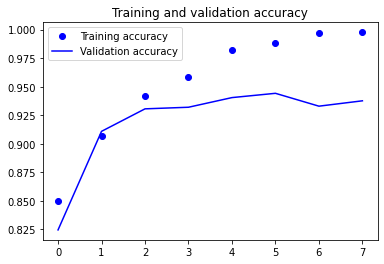

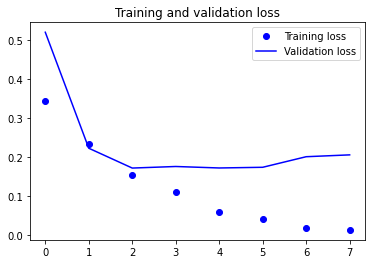

In [79]:
run_model(model8, 'Experiment8_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8768    0.8693    0.8730       696
           1     0.9369    0.9408    0.9388      1436

    accuracy                         0.9174      2132
   macro avg     0.9069    0.9050    0.9059      2132
weighted avg     0.9173    0.9174    0.9174      2132



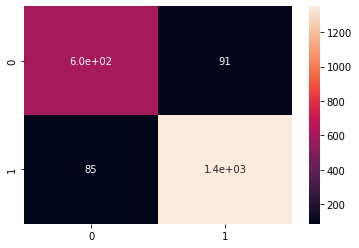

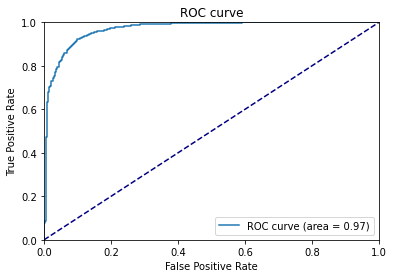

In [80]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment8_remove_blocks_fine_tuning.h5'))

##### Experiment 9: one dense layer with 512 neurons

In [81]:
model9 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model9.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model9, learning_rate=1e-5)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_8 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_8 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513 

Epoch 1/30
200/200 [==============================] - 584s 3s/step - loss: 0.3132 - accuracy: 0.8693 - val_loss: 0.5892 - val_accuracy: 0.8100

Epoch 00001: val_loss improved from inf to 0.58918, saving model to content/models/Experiment9_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 589s 3s/step - loss: 0.2048 - accuracy: 0.9182 - val_loss: 0.2275 - val_accuracy: 0.9118

Epoch 00002: val_loss improved from 0.58918 to 0.22748, saving model to content/models/Experiment9_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 579s 3s/step - loss: 0.1296 - accuracy: 0.9522 - val_loss: 0.1748 - val_accuracy: 0.9348

Epoch 00003: val_loss improved from 0.22748 to 0.17482, saving model to content/models/Experiment9_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 580s 3s/step - loss: 0.0843 - accuracy: 0.9740 - val_loss: 0.1711 - val_accuracy: 0.9348

Epoch 00004: val_loss improved from 0.17482 to 0.17107, saving model to content/models/Experiment9_remove_blocks_fine_tuning.h5
Epoch 5/30
200/200 [==============================] - 577s 3s/step - loss: 0.0449 - accuracy: 0.9889 - val_loss: 0.1899 - val_accuracy: 0.9320

Epoch 00005: val_loss did not improve fr

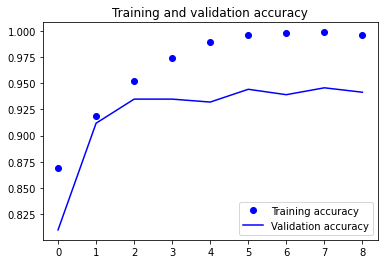

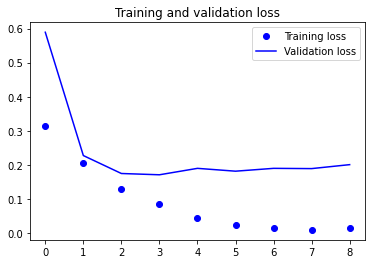

In [82]:
run_model(model9, 'Experiment9_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8569    0.9037    0.8797       696
           1     0.9521    0.9269    0.9393      1436

    accuracy                         0.9193      2132
   macro avg     0.9045    0.9153    0.9095      2132
weighted avg     0.9210    0.9193    0.9199      2132



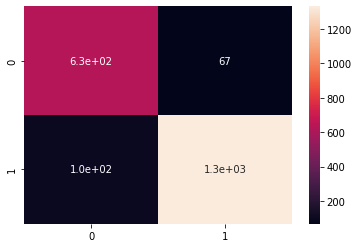

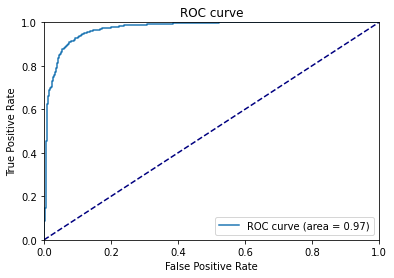

In [83]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment9_remove_blocks_fine_tuning.h5'))

#### Unfreeze all the base network
Let's try to unfreeze all the layers of the base network

##### Experiment 10: one dense layer with 256 neurons and dropout

In [84]:
model10 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')
model10.trainable = True
compile_model(model10, learning_rate=1e-5)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

Epoch 1/30
200/200 [==============================] - 634s 3s/step - loss: 0.3345 - accuracy: 0.8626 - val_loss: 0.7564 - val_accuracy: 0.7955

Epoch 00001: val_loss improved from inf to 0.75637, saving model to content/models/Experiment10_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 625s 3s/step - loss: 0.2231 - accuracy: 0.9074 - val_loss: 0.2621 - val_accuracy: 0.8973

Epoch 00002: val_loss improved from 0.75637 to 0.26209, saving model to content/models/Experiment10_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 629s 3s/step - loss: 0.1447 - accuracy: 0.9440 - val_loss: 0.1680 - val_accuracy: 0.9395

Epoch 00003: val_loss improved from 0.26209 to 0.16800, saving model to content/models/Experiment10_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 626s 3s/step - loss: 0.0944 - accuracy: 0.9672 - val_loss: 0.1655 - val_accuracy: 0.9386

Epoch 00004: val_loss improved from 0.16800 to 0.16554, saving model to content/models/Experiment10_remove_blocks_fine_tuning.h5
Epoch 5/30
200/200 [==============================] - 625s 3s/step - loss: 0.0530 - accuracy: 0.9841 - val_loss: 0.1638 - val_accuracy: 0.9414

Epoch 00005: val_loss improved from 0

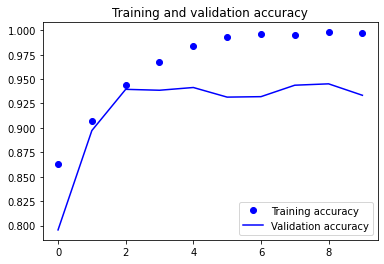

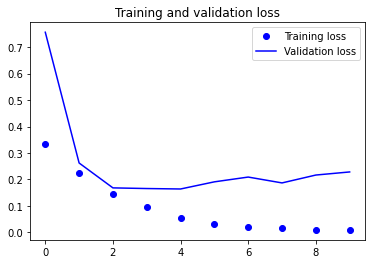

In [85]:
run_model(model10, 'Experiment10_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8884    0.9267    0.9072       696
           1     0.9637    0.9436    0.9536      1436

    accuracy                         0.9381      2132
   macro avg     0.9261    0.9352    0.9304      2132
weighted avg     0.9391    0.9381    0.9384      2132



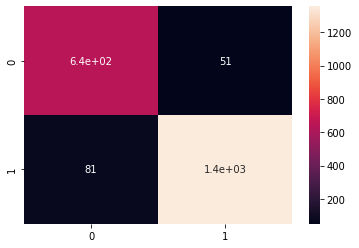

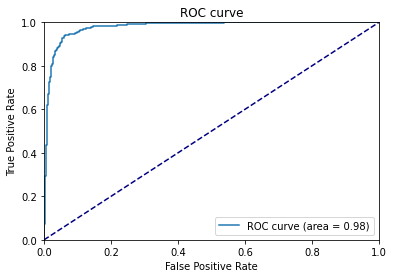

In [86]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment10_remove_blocks_fine_tuning.h5'))

##### Experiment 11: one dense layer with 512 neurons

In [87]:
model11 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
model11.trainable = True
compile_model(model11, learning_rate=1e-5)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_8 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_8 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513 

Epoch 1/30
200/200 [==============================] - 638s 3s/step - loss: 0.3035 - accuracy: 0.8752 - val_loss: 0.8090 - val_accuracy: 0.7861

Epoch 00001: val_loss improved from inf to 0.80902, saving model to content/models/Experiment11_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 625s 3s/step - loss: 0.1947 - accuracy: 0.9281 - val_loss: 0.2978 - val_accuracy: 0.8837

Epoch 00002: val_loss improved from 0.80902 to 0.29777, saving model to content/models/Experiment11_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 626s 3s/step - loss: 0.1256 - accuracy: 0.9554 - val_loss: 0.1944 - val_accuracy: 0.9282

Epoch 00003: val_loss improved from 0.29777 to 0.19441, saving model to content/models/Experiment11_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 624s 3s/step - loss: 0.0742 - accuracy: 0.9783 - val_loss: 0.1769 - val_accuracy: 0.9339

Epoch 00004: val_loss improved from 0.19441 to 0.17695, saving model to content/models/Experiment11_remove_blocks_fine_tuning.h5
Epoch 5/30
200/200 [==============================] - 628s 3s/step - loss: 0.0439 - accuracy: 0.9884 - val_loss: 0.1584 - val_accuracy: 0.9442

Epoch 00005: val_loss improved from 0

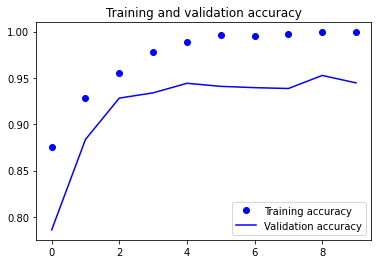

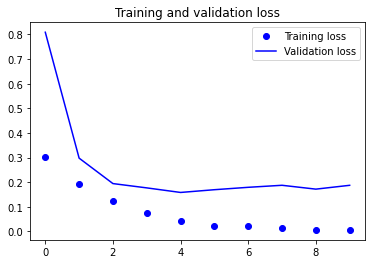

In [88]:
run_model(model11, 'Experiment11_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8841    0.9210    0.9022       696
           1     0.9609    0.9415    0.9511      1436

    accuracy                         0.9348      2132
   macro avg     0.9225    0.9312    0.9266      2132
weighted avg     0.9358    0.9348    0.9351      2132



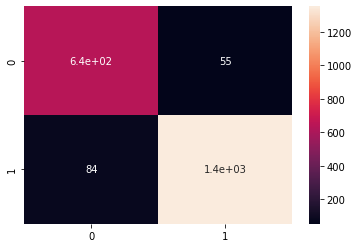

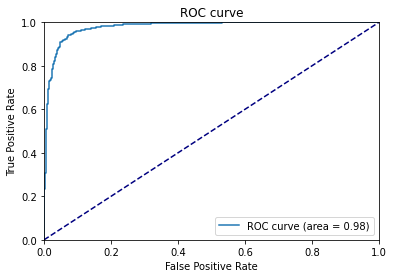

In [89]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment11_remove_blocks_fine_tuning.h5'))

##### Experiment 12: two dense layers of 512 neurons 

In [90]:
model12 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5')
model12.trainable = True
compile_model(model12, learning_rate=1e-5)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_9 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 14, 14, 1024)      8589184   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               2626

Epoch 1/30
200/200 [==============================] - 638s 3s/step - loss: 0.3073 - accuracy: 0.8702 - val_loss: 0.5885 - val_accuracy: 0.7871

Epoch 00001: val_loss improved from inf to 0.58850, saving model to content/models/Experiment12_remove_blocks_fine_tuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 629s 3s/step - loss: 0.2002 - accuracy: 0.9229 - val_loss: 0.2851 - val_accuracy: 0.8846

Epoch 00002: val_loss improved from 0.58850 to 0.28506, saving model to content/models/Experiment12_remove_blocks_fine_tuning.h5
Epoch 3/30
200/200 [==============================] - 630s 3s/step - loss: 0.1365 - accuracy: 0.9512 - val_loss: 0.2065 - val_accuracy: 0.9165

Epoch 00003: val_loss improved from 0.28506 to 0.20646, saving model to content/models/Experiment12_remove_blocks_fine_tuning.h5
Epoch 4/30
200/200 [==============================] - 631s 3s/step - loss: 0.0781 - accuracy: 0.9761 - val_loss: 0.2363 - val_accuracy: 0.9132

Epoch 00004: val_loss did not improve from 0.20646
Epoch 5/30
200/200 [==============================] - 629s 3s/step - loss: 0.0438 - accuracy: 0.9875 - val_loss: 0.1887 - val_accuracy: 0.9376

Epoch 00005: val_loss improved from 0.20646 to 0.18866, saving model to content/models/Experiment12_remove_blocks_f

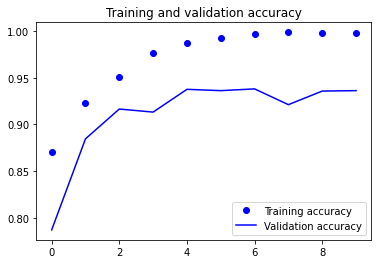

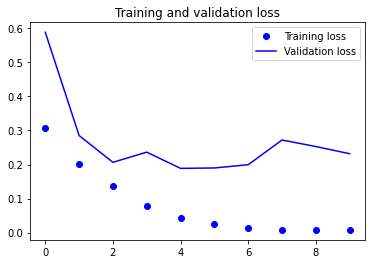

In [91]:
run_model(model12, 'Experiment12_remove_blocks_fine_tuning', epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8549    0.9224    0.8874       696
           1     0.9609    0.9241    0.9421      1436

    accuracy                         0.9235      2132
   macro avg     0.9079    0.9233    0.9147      2132
weighted avg     0.9263    0.9235    0.9243      2132



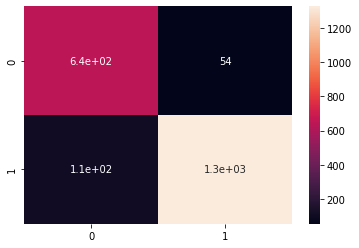

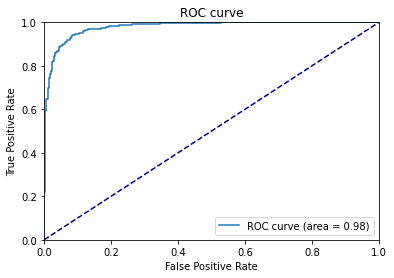

In [92]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment12_remove_blocks_fine_tuning.h5'))

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np


# Load the trained model
model_path = "content/drive/My Drive/Baldi_Cioffo/models/resnet-50/Experiment11_remove_blocks_fine_tuning.h5"
model = tf.keras.models.load_model(model_path)

# Function to preprocess the image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Provide the path of the image you want to predict
image_path = "Test2.bmp"

# Preprocess the image
target_size = (224,224)  # Use the same target size used during training
image_array = preprocess_image(image_path, target_size)

# Make the prediction
prediction = model.predict(image_array)
class_labels = ['hem', 'all']  # The class labels in the order used during training
predicted_class_index = np.argmax(prediction)
predicted_class = class_labels[predicted_class_index]

print("Predicted class:", predicted_class)


Predicted class: hem
